### Notebook to genereate binned ISENTROPIC cross sections from TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
4/23/22

In [56]:
# NOTE: Using copied tracking from CTL for NCRF tests

from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import subprocess
import sys
from thermo_functions import theta_virtual, relh, theta_equiv, density_moist
from mask_tc_track import mask_tc_track

#### Main settings

In [57]:
# Index variable (2D; independent var)
ivar_select = 'th_e'
# options (requiring 3D info): th_e

# Fill variable (3D; dependent var)
fillvar_select = 'vmf'
# options: avor, lwcrf, tprm, dbz, rh, vmf

# Contour variable (3D; dependent var)
contvar_select = 'w'

# Mask out all points except [stratiform/nonrain/etc], or switch off
# istrat=2 # 0-non-raining, 1-conv, 2-strat, 3-other/anvil, (-1 for off)
istrat=2

#### Additional settings and directories

In [58]:
storm = 'haiyan'
storm = 'maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'

# Tests to read and compare
# tests = ['crfon','ncrf']
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

# Shift starting-read time step for CRFON comparison
t0_test=0
if tests[0] == 'crfon':
    t0_test=24
    memb0=5 # for CRFFON test

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
enstag = str(nmem)
# Starting member to read
memb0=1

nums=np.arange(memb0,nmem+memb0,1); nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

# TC tracking
ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 8 # radius (deg) limit for masking around TC center

# Strat/Conv index subset
if istrat == -1:
    strattag='All'
elif istrat == 0:
    strattag='Nonrain'
elif istrat == 1:
    strattag='Conv'
elif istrat == 2:
    strattag='Strat'
elif istrat == 3:
    strattag='Anv'
fig_extra='_'+strattag.lower()

In [59]:
datdir2 = 'post/d02/'

##### Get dimensions

datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
datdir3d = datdir #+'v2/'
varfil_main = Dataset(datdir3d+'T.nc')
nz = varfil_main.dimensions['level'].size
# lat = varfil_main.variables['XLAT'][:][0] # deg
# lon = varfil_main.variables['XLONG'][:][0] # deg
nx1 = varfil_main.dimensions['lat'].size
nx2 = varfil_main.dimensions['lon'].size
pres = varfil_main.variables['pres'][:] # hPa
dp = (pres[1]-pres[0])*1e2 # Pa
varfil_main.close()

process = subprocess.Popen(['ls '+main+storm+'/'+memb_all[0]+'/'+tests[0]+'/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
varfil_main.close()

#### NetCDF variable read functions

In [60]:
def var_read_3d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    return var
def var_read_2d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    return var

#### Index aka Bin variable

In [61]:
# Variable settings

# Theta-e
if ivar_select == 'th_e':
    fmin=315; fmax=365 # K
    step=1
    bins=np.arange(fmin,fmax+step,step)
    xlabel=r'$\theta_e$ [K]'
    log_x='linear'

nbins = np.size(bins)

# Create axis of bin center-points for plotting
bin_axis = (bins[np.arange(nbins-1)]+bins[np.arange(nbins-1)+1])/2

#### Main loops and compositing

In [62]:
# # Main read loops for 3D (dependent) variables

# # Arrays to save variables
# ntest=2
# var_all = np.ma.zeros((ntest,nmem,nt,nz,nx1,nx2))
# ivar_all = np.ma.zeros((ntest,nmem,nt,nz,nx1,nx2))
# # cvar_all = np.ma.zeros((ntest,nmem,nt,nz,nx1,nx2))
# # strat_all = np.ma.zeros((ntest,nmem,nt,nx1,nx2))

# var_binned=np.ma.zeros((ntest,nmem,nt,nz,nbins-1))

# for ktest in range(ntest):

#     test_str=tests[ktest]

#     # This has been tested for corresponding time steps:
#     #   t0=37,1 are the first divergent time steps in CTL,NCRF
#     #   t0=25,1 are the first divergent time steps in NCRF,CRFON
#     if test_str == 'ctl':
#         if tests[1] == 'ncrf36h':
#             t0=36
#         elif tests[1] == 'ncrf48h':
#             t0=48
#     elif test_str == 'ncrf36h':
#         t0=t0_test
#     elif test_str == 'ncrf48h':
#         t0=t0_test
#     elif test_str == 'crfon':
#         t0=0

#     t0+=1 # add one time step since NCRF(t=0) = CTL
#     t1 = t0+nt

#     print('Running test: ',test_str)

#     # Loop over ensemble members

#     for imemb in range(nmem):
    
#         print('Running imemb: ',memb_all[imemb])
    
#         datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
#         datdir3d = datdir #+'v2/'
#         print(datdir)

#         # Localize to TC track
#         # NOTE: Using copied tracking from CTL for NCRF tests
#         # track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'
#         trackfil_ex=''
#         if 'crf' in test_str:
#             trackfil_ex='_ctlcopy'
#         track_file = datdir+'../../track_'+var_track+trackfil_ex+'_'+ptrack+'hPa.nc'


#         # Required variables

#         # Stratiform index
#         if istrat != -1:
#             varname = 'strat'
#             strat = var_read_2d(datdir,varname,t0,t1) # 0-non-raining, 1-conv, 2-strat, 3-other/anvil

#         # Index AKA Bin variable ("ivar")

#         # Theta-e (equivalent potential temperature)
#         # if ivar_select == 'th_e':
#         varname='T'
#         tmpk = var_read_3d(datdir3d,varname,t0,t1) # K
#         varname = 'QVAPOR'
#         qv = var_read_3d(datdir3d,varname,t0,t1) # kg/kg
#         ivar = theta_equiv(tmpk,qv,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
        
#         # Three-dimensional dependent variables ("var")

#         # Vertical mass flux
#         # if fillvar_select == 'vmf':
#         varname='W'
#         var = var_read_3d(datdir3d,varname,t0,t1) # m/s
#         var *= density_moist(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # kg/m3

#         ### Process and save variable ##############################################

#         # Mask out based on strat/conv
#         if istrat != -1:
#             var = np.ma.masked_where((np.repeat(strat,nz,axis=1) != istrat), var, copy=True)
#             # cvar = np.ma.masked_where((np.repeat(strat,nz,axis=1) != istrat), cvar, copy=True)
#             ivar = np.ma.masked_where((np.repeat(strat,nz,axis=1) != istrat), ivar, copy=True)

#         # Localize to TC track
#         var = mask_tc_track(track_file, rmax, var, lon, lat, t0, t1)
#         # cvar = mask_tc_track(track_file, rmax, cvar, lon, lat, t0, t1)
#         ivar = mask_tc_track(track_file, rmax, ivar, lon, lat, t0, t1)
#         # strat = mask_tc_track(track_file, rmax, strat, lon, lat, t0, t1)

#         # Save ens member
#         var_all[ktest,imemb,:,:,:,:]  = var
#         ivar_all[ktest,imemb,:,:,:,:]  = ivar
#         # cvar_all[ktest,imemb,:,:,:,:] = cvar
#         # strat_all[ktest,imemb,:,:,:]  = strat[:,0,:,:]

#         # Bin the variables from (x,y) --> (bin)
#         for it in range(nt):
#             for ik in range(nz):
#                 for ibin in range(nbins-1):
#                     indices = ((ivar_all[ktest,:,it,ik,:,:] >= bins[ibin]) & (ivar_all[ktest,:,it,ik,:,:] < bins[ibin+1])).nonzero()
#                     if indices[0].shape[0] > 3:
#                         var_binned[ktest,imemb,it,ik,ibin] = np.sum(var_all[ktest,indices[0],it,ik,indices[1],indices[2]], dtype=np.float64)
#                     else:
#                         var_binned[ktest,imemb,it,ik,ibin] = np.nan

In [63]:
# Just reading in isentreopic data

# Settings based on how data was written out:
# Number of sample time steps
nt=12
hr_tag = str(np.char.zfill(str(nt), 2))

# Arrays to save variables
ntest=2
var_binned=np.zeros((ntest,nmem,nt,nz,nbins-1))
ivar_mean=np.zeros((ntest,nmem,nt,nz))

for ktest in range(ntest):

    test_str=tests[ktest]

    # This has been tested for corresponding time steps:
    #   t0=37,1 are the first divergent time steps in CTL,NCRF
    #   t0=25,1 are the first divergent time steps in NCRF,CRFON
    if test_str == 'ctl':
        if tests[1] == 'ncrf36h':
            t0=36
        elif tests[1] == 'ncrf48h':
            t0=48
    elif test_str == 'ncrf36h':
        t0=t0_test
    elif test_str == 'ncrf48h':
        t0=t0_test
    elif test_str == 'crfon':
        t0=0

    t0+=1 # add one time step since NCRF(t=0) = CTL
    t1 = t0+nt

    print('Running test: ',test_str)

    # Loop over ensemble members

    for imemb in range(nmem):
    
        # print('Running imemb: ',memb_all[imemb])
    
        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
        datdir3d = datdir #+'v2/'

        # Read isentropic data
        file_out = datdir+'isent_vmf_'+strattag.lower()+'_'+hr_tag+'hr.nc'
        # print(file_out)
        ncfile = Dataset(file_out,mode='r')
        # print(ncfile.variables)
        bin_axis = ncfile.variables['bins'][:]
        
        readin = ncfile.variables['vmf'][:,:,:]
        var_binned[ktest,imemb,:,:,:] = ncfile.variables['vmf'][:,:,:]
        ivar_mean[ktest,imemb,:,:] = ncfile.variables['th_e'][:,:]
        
        ncfile.close()

# #### Average variables across time and ens member
var_binned = np.mean(var_binned, axis=1)
ivar_mean = np.mean(ivar_mean, axis=1)

Running test:  ctl
Running test:  ncrf48h


---
### Plotting routines

In [64]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

### Figure settings

In [65]:
# Three-dimensional dependent variables ("var")

# Vertical mass flux
if fillvar_select == 'vmf':
    title = 'VMF'
    figtag = fillvar_select
    scale=1e-2
    units_var1 = '10$^2$ kg/s/K'
    xrange=[320,360]
    cmap='RdBu_r'
    cmax=10; cmin=-1*cmax
    cmax_diff=0.5; cmin_diff=-1*cmax_diff

### Main Cross Section

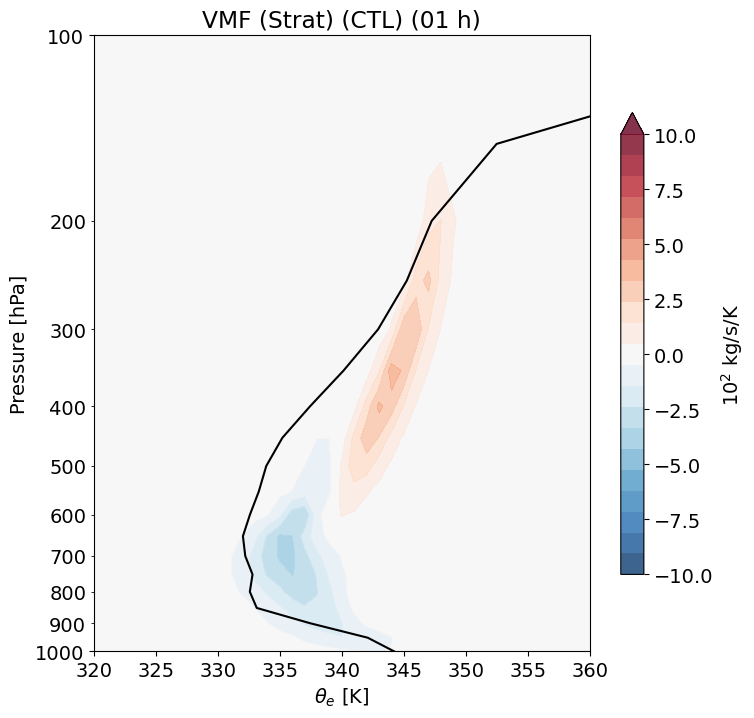

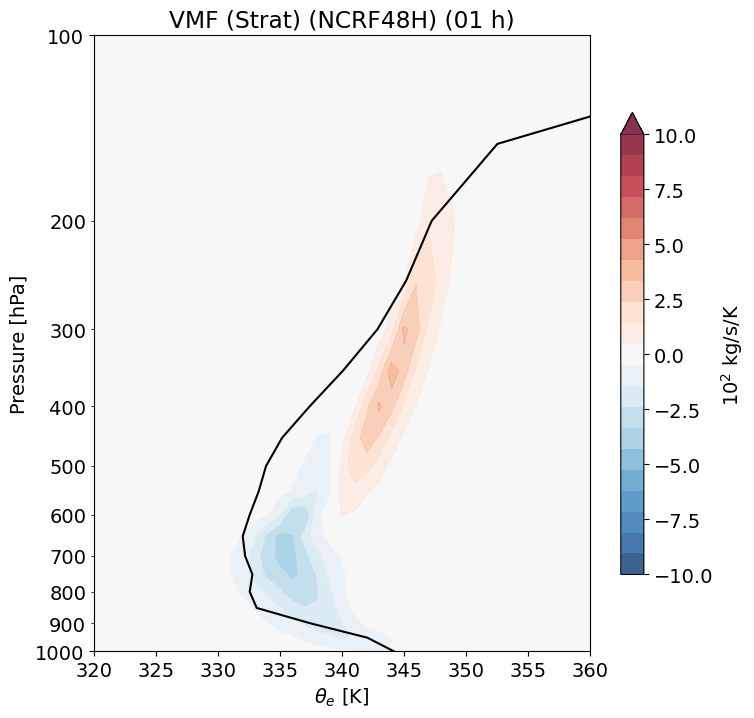

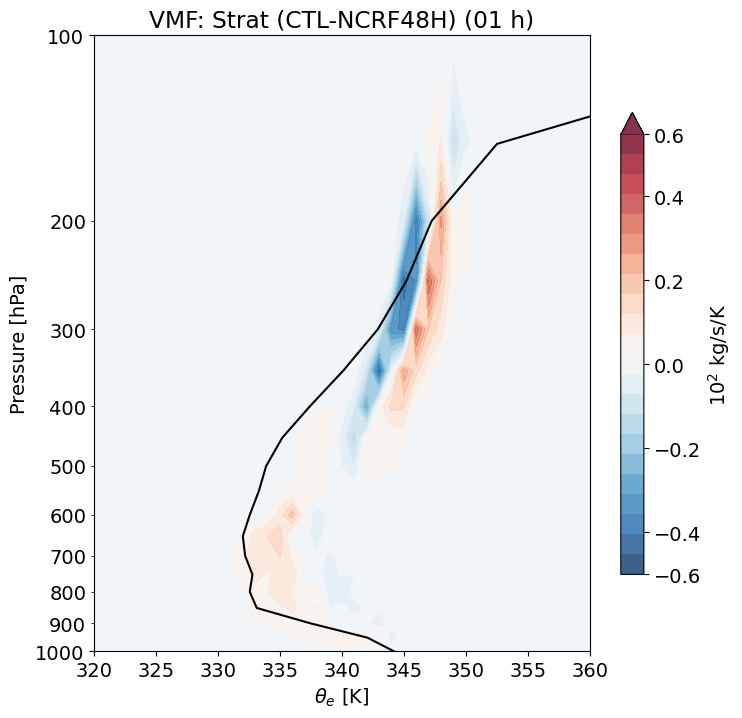

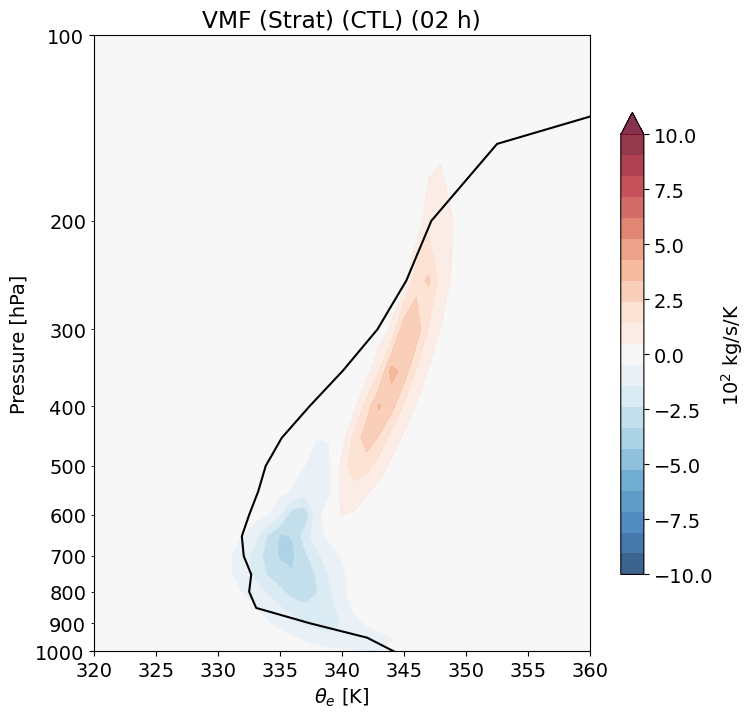

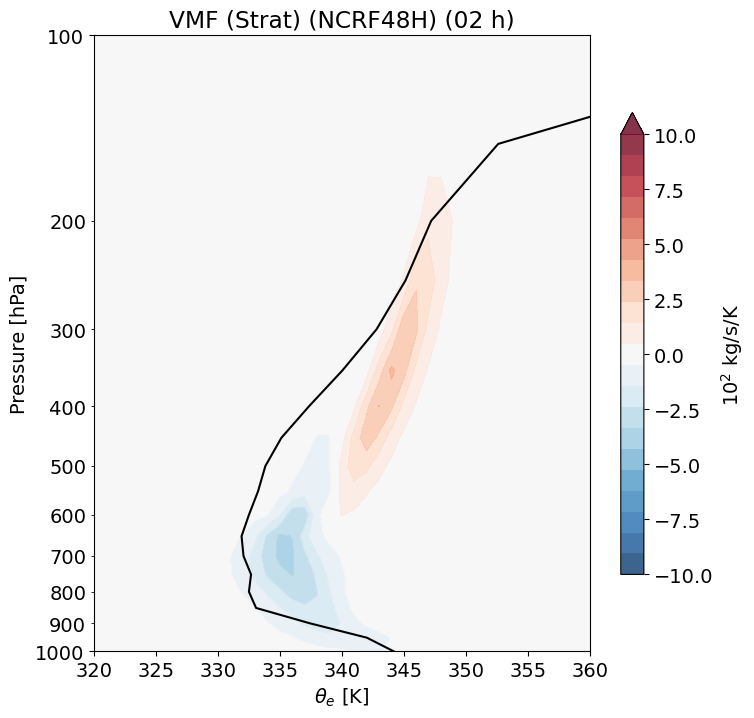

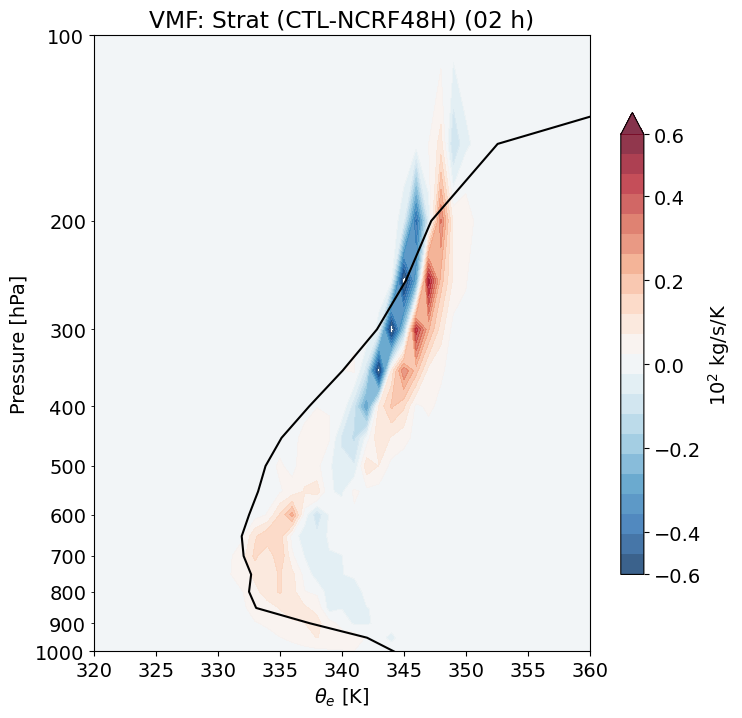

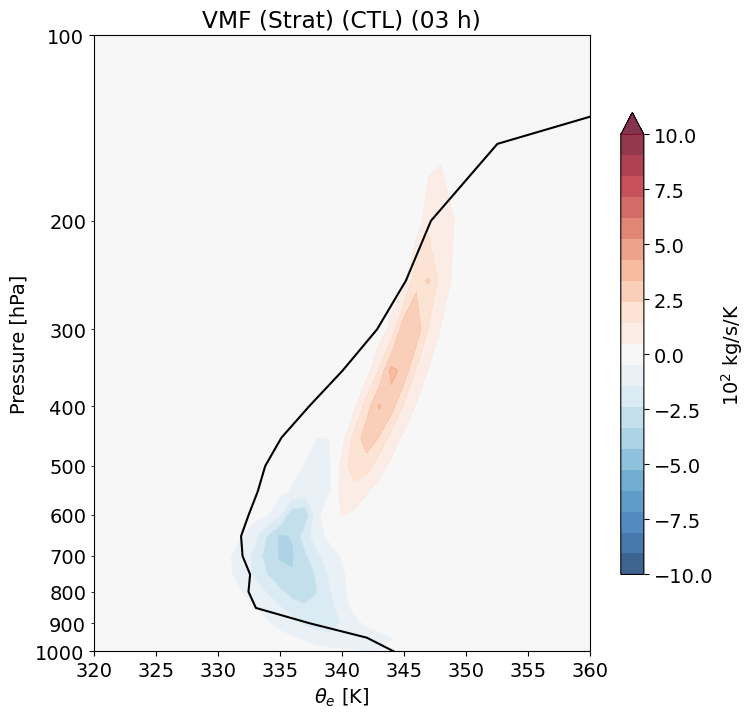

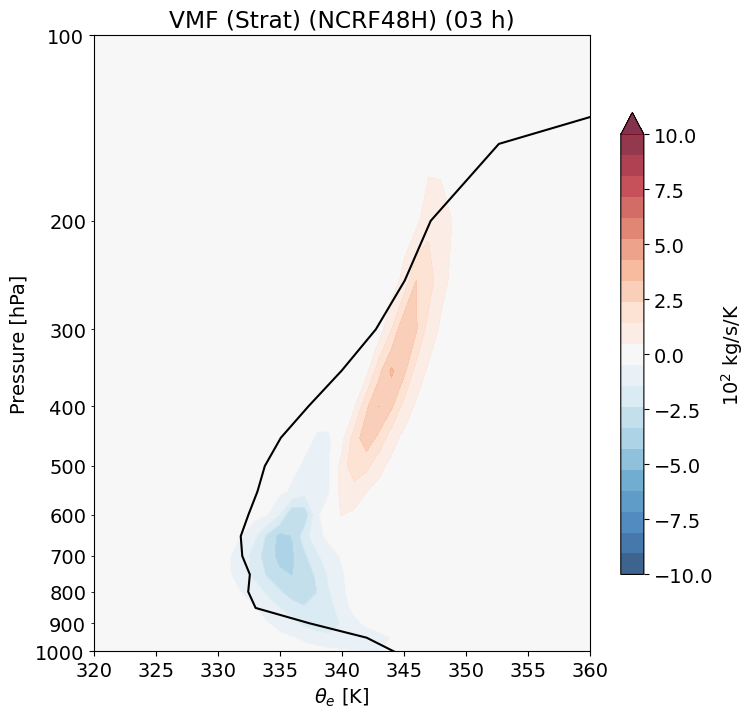

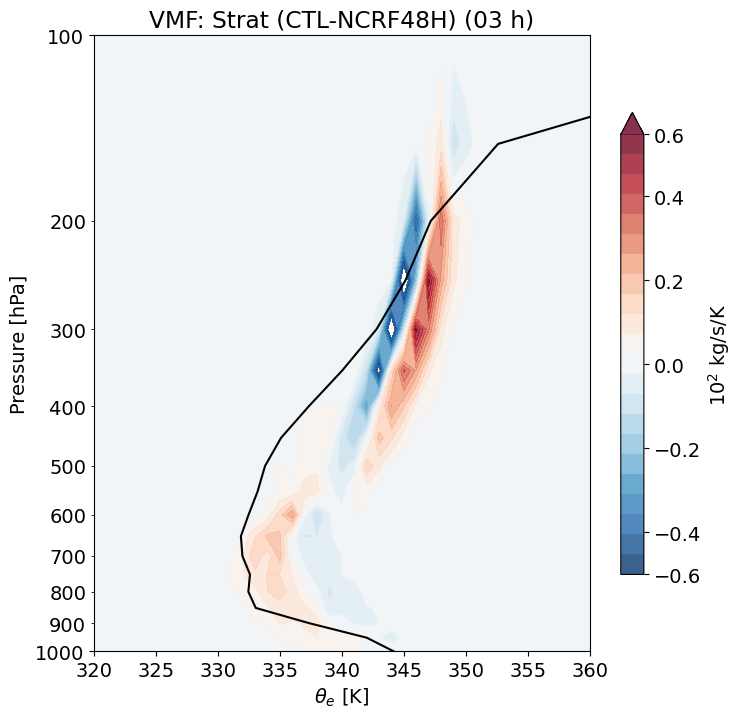

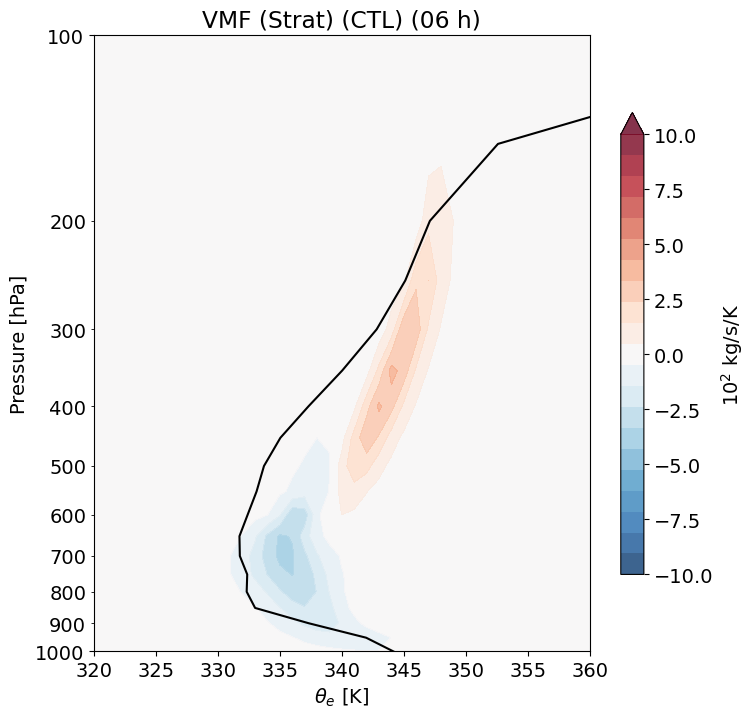

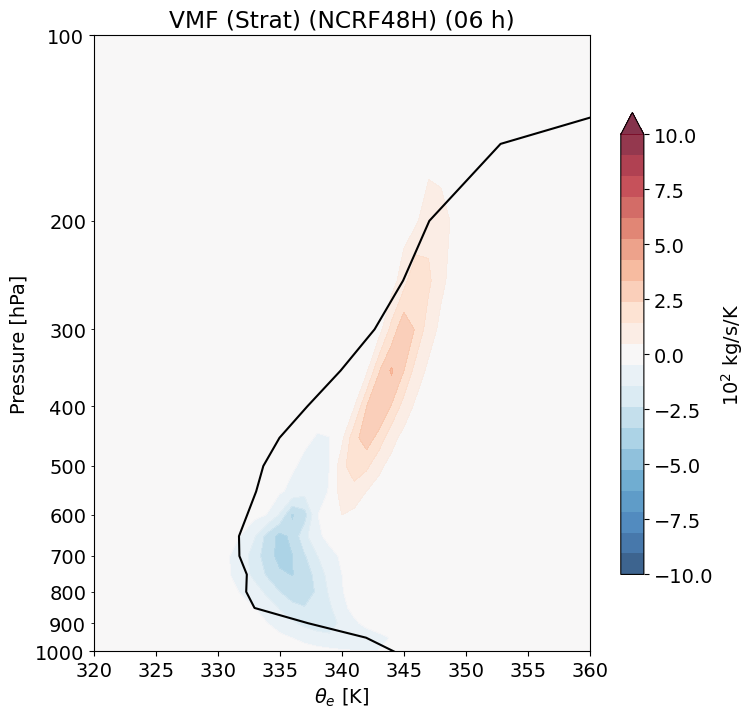

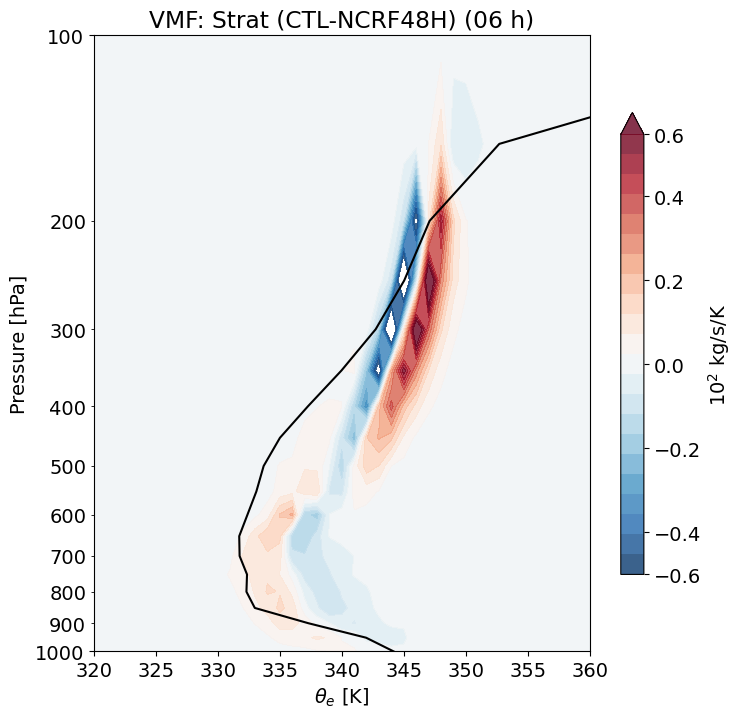

In [66]:
ntall=[1,2,3,6]
# ntall=[3]
nntall=np.shape(ntall)[0]

for knt in range(nntall):

    i_nt=ntall[knt]
    hr_tag = str(np.char.zfill(str(i_nt), 2))

    # #### Average variables across time and ens member
    ivar_mn = np.mean(ivar_mean[:,0:i_nt,:], axis=1)
    ivar_binned = np.mean(var_binned[:,0:i_nt,:,:], axis=1)

    # Loop over sensitivity tests
    for ktest in range(ntest):

        test_str=tests[ktest].upper()
        fig_title = title+' ('+strattag+') ('+test_str.upper()+') ('+hr_tag+' h)'
        
        # create figure
        # fig = plt.figure(figsize=(14,8))
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)

        ax.set_title(fig_title)
        ax.set_ylabel('Pressure [hPa]')

        pltvar=ivar_binned[ktest,:,:]*scale

        # fill contour
        nlevs=21
        inc=(cmax-cmin)/nlevs
        clevs = np.arange(cmin, cmax+inc, inc)
        im = ax.contourf(bins[0:nbins-1], pres, pltvar, clevs, cmap=cmap, alpha=0.8, \
                        extend='max', zorder=2)

        cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
        cbar.ax.set_ylabel(units_var1)
        
        plt.ylim(100,np.max(pres))
        ax.invert_yaxis()
        ax.set_yscale('log')
        ax.set_xscale(log_x)
        ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

        ax.set_xlabel(xlabel)
        # plt.xlim(np.min(bins), np.max(bins))
        plt.xlim(xrange)

        # Plot mean theta-e profile
        plt.plot(ivar_mn[ktest,:], pres, "-k")

        # ax2=ax.twinx()
        # im = ax.plot(bins[0:nbins-1], binvar_s_mn)

        # # line contour
        # strmfn = np.zeros((nz,nbins))
        # for ik in range(nz):
        #     for ibin in range(1,nbins-1):
        #         if np.isnan(var_binned[ktest,ik,ibin]):
        #             continue
        #         strmfn[ik,ibin] = strmfn[ik,ibin-1] + var_binned[ktest,ik,ibin]
        # stm_inc=3
        # clevs = np.arange(stm_inc, 20*stm_inc, stm_inc)
        # clevs = np.concatenate((-1*np.flip(clevs),clevs))
        # cvar = strmfn*1e-2
        # im = ax.contour(bins, pres, cvar, clevs, colors='black', zorder=2)
        # ax.clabel(im, im.levels, inline=True, fontsize=13)

        figtag2 = figtag+'_'+ivar_select+fig_extra
        plt.savefig(figdir+'binnedcross_'+figtag2+'_'+tests[ktest].lower()+'_ens'+enstag+'m_'+hr_tag+'.png',dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()


    # DIFFERENCE PLOT between sensitivity tests

    fig_title = title+': '+strattag+' ('+tests[0].upper()+'-'+tests[1].upper()+') ('+hr_tag+' h)'

    # create figure
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    ax.set_title(fig_title)
    ax.set_ylabel('Pressure [hPa]')

    pltvar =  ivar_binned[0,:,:] - ivar_binned[1,:,:]
    pltvar*=scale

    # fill contour
    nlevs=21
    inc=(cmax_diff-cmin_diff)/nlevs
    clevs = np.arange(cmin_diff, cmax_diff+inc, inc)
    im = ax.contourf(bins[0:nbins-1], pres, pltvar, clevs, cmap='RdBu_r', alpha=0.8, \
                    extend='max', zorder=2)

    cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel(units_var1)

    plt.ylim(100,np.max(pres))
    ax.invert_yaxis()
    ax.set_yscale('log')
    ax.set_xscale(log_x)
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

    ax.set_xlabel(xlabel)
    # plt.xlim(np.min(bins), np.max(bins))
    plt.xlim(xrange)

    # Plot mean theta-e profile
    plt.plot(np.mean(ivar_mn,axis=0), pres, "-k")

    figtag2 = figtag+'_'+ivar_select+fig_extra
    plt.savefig(figdir+'binnedcross_'+figtag2+'_diff_ens'+enstag+'m_'+hr_tag+'.png',dpi=200, facecolor='white', \
                bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()